# Facial emotion detection using a pre-trained model

This notebook is for testing my pre-trained facial emotion model on .mp4 video files.



In [1]:
!pip install kwargs  
!pip install cinit 
!pip install opencv-python

  Created wheel for cinit: filename=cinit-0.1.0-py3-none-any.whl size=2483 sha256=b7b1d5a257d58f2493a02d43da0cae6f92c9ea8502ee296a449654cc8452a0af
  Stored in directory: /root/.cache/pip/wheels/91/3f/1d/107e7a9f4fe2928b03f075369470090941f7d217bbaeab9aed
Successfully built cinit


In [63]:
import sys, os, keras, cv2, sys
import numpy as np, tensorflow as tf
from matplotlib import pyplot as plt

**Video frame counter helper funciton**

We need this function to help with downsampling frames from video to help with keeping memory usage to a minimum.

In [3]:
def count_frames(video_path):
  cap, num_frames = cv2.VideoCapture(video_path), 0
  while (cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
      return num_frames;
    num_frames += 1 

**Face detection and extraction helper functions**

This function detects faces from video using a pretrained model. It then returns bounding box coordinates for the first face detected.

In [4]:
def detect_face(img, face_bb_detector):
  # detect faces
  faces = face_bb_detector.detectMultiScale(img, 1.1, 4)
  if (faces==()):
    return False, (), ()
  else:
    x, y, w, h = faces[0]
    return True, (x, y), (x+w, y+h)


This function extracts a face from the inputted image given a bounding box (x, y, x+w, y+h)

In [5]:

def extract_face(img, bb0, bb1, width=48, height=48):
  return cv2.resize( img[bb0[1]:bb1[1], bb0[0]:bb1[0]],  (width, height), fx = 0, fy = 0, interpolation = cv2.INTER_CUBIC)


**Loading facial classifier and extracting emotion probabilities sentiment from frames**

The first function is for loading the pre-built facial emotion classifier.

The second function is for returning an array of predicted emotion for given frames. 

In [6]:
def get_pretrained_face_classifier(path):
  if not(os.path.isfile(path)):
    return False, None
  else:
    return True, tf.keras.models.load_model(path)

def classify_emotion(images, classifier):
  pre_processed_frames = np.asarray(images, dtype=np.float32) / 255.0
  return classifier.predict(pre_processed_frames)


**Creating emotion sentiment timeline from a video**

In [46]:
def analyse_video(video_path, classifier, face_bb_detector):
  if not(os.path.isfile(video_path)):
    raise ValueError("Video could not be found")
  if classifier == None:
    raise ValueError("Facial classifier could not be loaded")

  # input video parameters
  captured_vid = cv2.VideoCapture(video_path) # get captured video source
  total_frames = count_frames(video_path)     # get total frames
  frame_number = 0                            # frame counter 
  frames       = []
  downsample_rate = 4                         # skip every 2nd frame 
  # loop until the end of the video
  while (captured_vid.isOpened()):
      # capture frame-by-frame
      ret, frame = captured_vid.read( cv2.IMREAD_GRAYSCALE)

      # if error reading / reached end, exit
      if not ret:
        break;

      # convert frame to grayscale 
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      frame = cv2.resize(frame, (640, 480), fx = 0, fy = 0, interpolation = cv2.INTER_CUBIC)
      # downsample frames every downsample_rate
      if frame_number % downsample_rate == 0:
        # detect face and extract its bounding box
        detected, bb0, bb1 = detect_face(frame, face_bb_detector)
        # if face detected, extract it 
        if (detected):
          extracted_face = extract_face(frame, bb0, bb1)          
          frames.append(extracted_face)
      frame_number += 1 

  # release the video capture object
  captured_vid.release()
  # closes all the windows currently opened.
  cv2.destroyAllWindows()
  
  return classify_emotion(frames, classifier)

In [22]:
face_bb_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
classifier_loaded, face_classifier = get_pretrained_face_classifier("facial_emotion_classifier.h5")

## **Results**

**Values explanations**: 1 means that the model has detected a positive emotion, 0 means it is detecting an absense of positiveness. 


**Test 1** - Getting positive probability distribution for a video with mixed emotions (emotion_mixed.mp4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


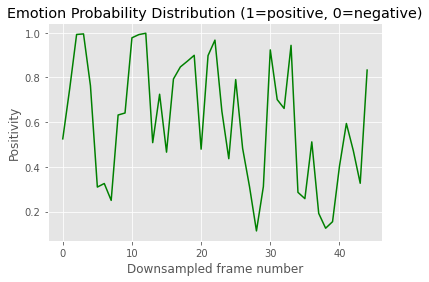

In [81]:
plt.style.use('ggplot')

video = "emotion_mixed.mp4"
probabilities = analyse_video(video, face_classifier, face_bb_detector)

x_data, y_data = [i for i in range(0,len(probabilities))], probabilities[:, [1]].flatten()
plt.plot(
    x_data
    , 
    y_data
    , 
    color='green'
)
plt.xlabel("Downsampled frame number")
plt.ylabel("Positivity")
plt.title("Emotion Probability Distribution (1=positive, 0=negative)")
plt.show()



**Mean sentiment**

From the results it shows that the model is detecting mixed sentiment overall.

In [75]:
np.mean(y_data)

0.6017643

**Test 2** - Getting positive probability distribution for a video with positive facial emotions (emotion_positive.mp4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


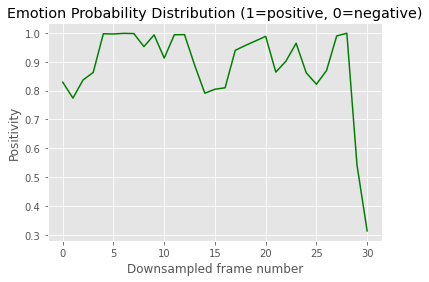

In [79]:
video = "emotion_positive.mp4"
probabilities = analyse_video(video, face_classifier, face_bb_detector)

x_data, y_data = [i for i in range(0,len(probabilities))], probabilities[:, [1]].flatten()
plt.plot(
    x_data
    , 
    y_data
    , 
    color='green'
)
plt.xlabel("Downsampled frame number")
plt.ylabel("Positivity")
plt.title("Emotion Probability Distribution (1=positive, 0=negative)")
plt.show()



**Test 3** - Getting positive probability distribution for a video with subtle negative emotions (emotion_negative.mp4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


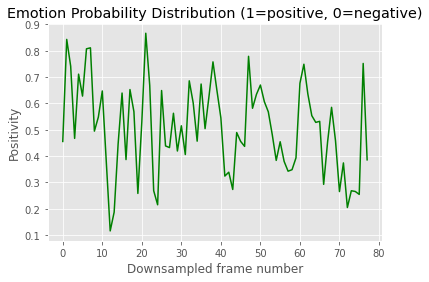

In [83]:
video = "emotion_negative.mp4"
probabilities = analyse_video(video, face_classifier, face_bb_detector)

x_data, y_data = [i for i in range(0,len(probabilities))], probabilities[:, [1]].flatten()
plt.plot(
    x_data
    , 
    y_data
    , 
    color='green'
)
plt.xlabel("Downsampled frame number")
plt.ylabel("Positivity")
plt.title("Emotion Probability Distribution (1=positive, 0=negative)")
plt.show()


In [84]:
np.mean(y_data)

0.5054625